# PyTorch Tutorial Workthrough

Here we work through a basic example in PyTorch. It is the example used in the [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html). The material heavily relies on the excellent material in that tutorial. The presentation is similar but with a slightly different emphasis. In particular this is written from the perspective of an econometrician and some parallels and differences to traditional econometric techniques will be pointed out.


## Load some libraries

In [58]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from datetime import datetime
import torchvision.models as models
import matplotlib.pyplot as plt

## Tensors

The PyTorch library expects data inputs as tensors. For example, here we load some inflation data

In [25]:
# Load the data
data = pd.read_csv('datasets/CPALTT01USM657N.csv')
data.tail()
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.rename(columns={'CPALTT01USM657N': 'inflation'})

,inflation
DATE,
1960-01-01,-0.340136
1960-01-02,0.341297
1960-01-03,0.000000
1960-01-04,0.340136
1960-01-05,0.000000
...,...
2023-01-03,0.331073
2023-01-04,0.505904
2023-01-05,0.251844


These can be transformed into a tensor like so, where we use the `values()` property of the dataframe. The resulting tensor has properties `shape` and `type` which give you the relevant shape and type information.

In [26]:
tensor = torch.tensor(data.values)
tensor.dtype
tensor.shape


torch.Size([763, 1])

Tensors are basically multi-dimensional matrices and you can do arithmatic with these. Find a [list of operations](https://pytorch.org/docs/stable/torch.html) to see what is available. 

## Example data

To follow the example in the PyTorch tutorial we need to load the Fashion-MNIST dataset. This dataset is already in the right format and we obtain a training and a testing portion for the dataset.

In [27]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

These are image data, for instance the first image `training_data[1]` gives you information on the 28x28 pixels of an image.

In [28]:
training_data[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
           0.0000, 0.0000, 0.1608, 0.7373, 0.4039, 0.2118, 0.1882, 0.1686,
           0.3412, 0.6588, 0.5216, 0.0627, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.1922,
           0.5333, 0.8588, 0.8471, 0.8941, 0.9255, 1.0000, 1.0000, 1.0000,
           1.0000, 0.8510, 0.8431, 0.9961, 0.9059, 0.6275, 0.1765, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0549, 0.6902, 0.8706,
           0.8784, 0.8314, 0.7961, 0.7765, 0.7686, 0.7843, 0.8431, 0.8000,
           0.7922, 0.7882, 0.7882, 0.7882, 0.8196, 0.8549, 0.8784, 0.6431,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7373, 0.8588, 0.7843,
           0.7765, 0.7922, 0.7765, 0.7804, 0.7804, 0.7882, 0.7686, 0.7765,
           0.7765, 0.7843, 0.7843, 0.7843, 

We can also visualise these images

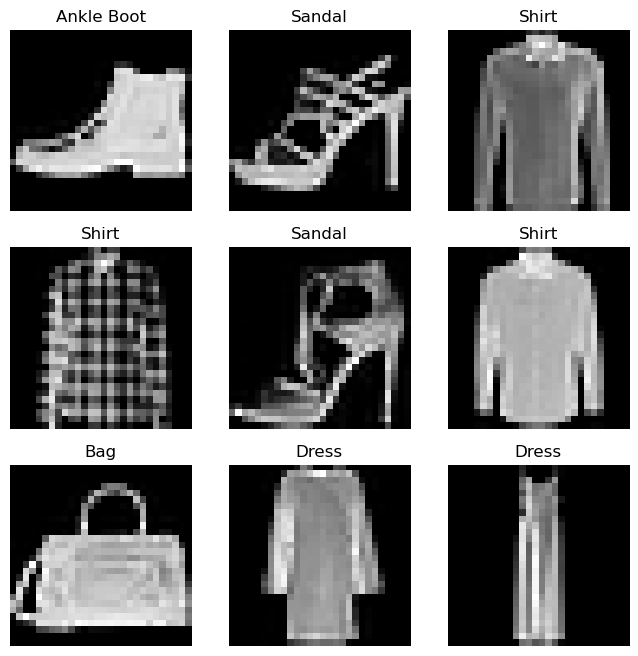

In [29]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We now have the data avaialable in `test_data` and `training_data`. For certain operations it will turn out to be useful to access the data via the DataLoader. This will enable access samples of data.

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

We indicated above that, if iterating through the data, we get random items. Each item has an image and a label.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


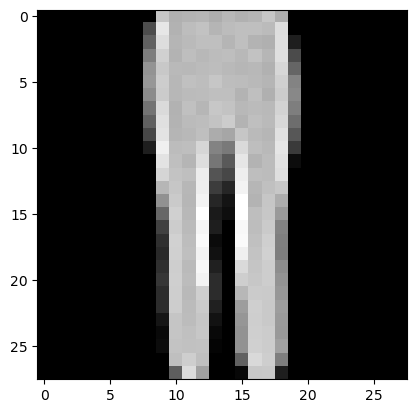

Label: 1


In [31]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [32]:
img, label = training_data[11]

## Data transformations

Neural Network models need data input in very controlled scales. Examples are standardised variables (mean 0 and variance 1) or data mapped into a $[0,1]$ interval. In fact, when we imported the Fashion data earlier, we called `transform=ToTensor()`. This ensured that the pixel information was mapped into the $[0,1]$ intervall. The `target` variable, which is the label, however, came as an integer in $[0,9]$. By reloading the data with the `target_transform` as below, we change the label into 10 indicator variables with all but one taking the value 0.



In [33]:
ds_train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

ds_test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

Let us extract the 15th item out of `ds_train`, show it and see what type of item it is.

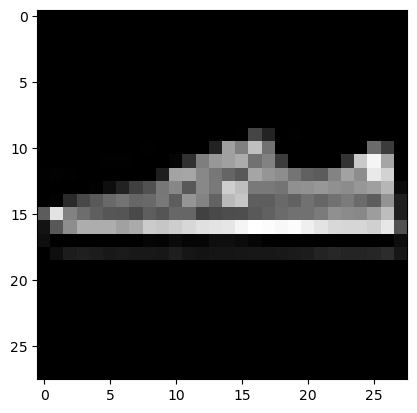

Label: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


In [34]:
img, label = ds_train[14]
img = img.squeeze()
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

You can see that the third last indicator variable is 1. That corresponds to label 7, a sneaker.

## Build the Model

Now that the data are prepared we need to build the model. This is done using the 

In [35]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We will return to the details of the above setup a little later. For now just accept it.

But what is useful to understand what the above code did. It defined a `class` called `NeuralNetwork`. This will allow us to soon define a particular object (in computing speak an "instance" of that type of object) of that class. More on this later. 

Estimating, or training in the language of machine learning, a neural network model can by computing intensive. So we want to use the best possible hardware to do so. The following bit of code checks whether you have any special resources available. If not, then your computer's CPU will be used.

In [36]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Now we shall define one instance of the `NeuralNetwork` type of objects, and we call it `model`.

In [37]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


You can see that the model eventually maps the 784 (28x28 pixels) into 10 output items (the 10 different labels). In other words, we feed in an image (as defined by 728 pixels) and we receive information in terms of 10 outputs (the 10 possible labels).

Let us now define a random image and then we print it.

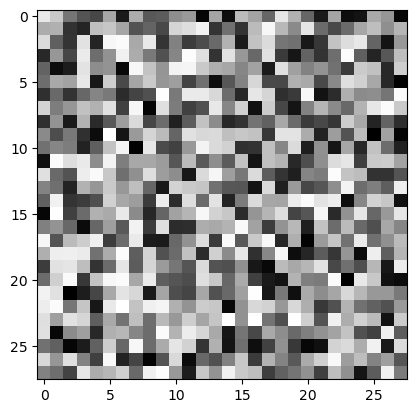

In [38]:
X = torch.rand(1, 28, 28, device=device)
plt.imshow(X.squeeze(), cmap="gray")
plt.show()


So this is just noise. We shouldn't expect to see any particular item of clothing in here. But anyways, let's see whether our Neural Network can detect anything.

In [39]:

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)

tensor([[0.1036, 0.0926, 0.1085, 0.0980, 0.1054, 0.1057, 0.0985, 0.0863, 0.0991,
         0.1022]], grad_fn=<SoftmaxBackward0>)


What you see here are the predicted probabilities for each of the 10 item classes (from t-shirt to ankle boots). You can see that these probabilities are all between 8 and 11% and in fact they sum to 1. This is not surprising as the random image does not look anythink like any of the items in our list. The max prob here is the probability of 10.55% for a bag.

Let's see how the model does with one of our images from the test dataset (`ds_test`). We will pick the 15th image from the training dataset. We'll first print the image.

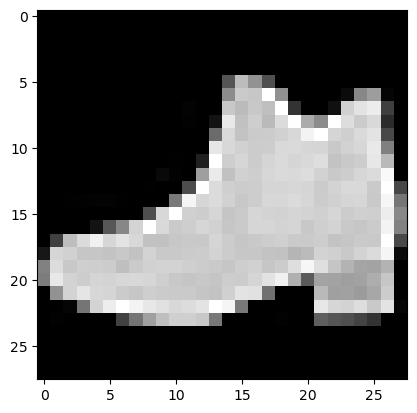

Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [40]:
img, label = ds_train[15]
img = img.squeeze()
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

This is an image of an ankle boot. Now we feed this into our network. Will it identify the picture as an ankle boot? `ds_test[15]` picks the 15th item but there are two elements, the image as the first element (`[0]`) and the label as the second element (`[1]`). So `ds_test[15][0]` picks the image only as we feed it into `model`

In [41]:

logits = model(ds_test[15][0])
pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)

tensor([[0.0998, 0.0984, 0.1002, 0.0960, 0.1046, 0.0995, 0.1004, 0.1011, 0.1008,
         0.0992]], grad_fn=<SoftmaxBackward0>)


The result is basically as for the random image. All labels have a probability around 10%. Why is that. Well, so far we only initiated a network architecture (which includes some random model coefficients). The network has not seen any data yet which it could use to optimise the parameters such that it recognises an ankle boot.

In fact you can see what the parameters for the model are (as we initialised it):

In [42]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0297,  0.0263,  0.0138,  ..., -0.0131,  0.0120, -0.0164],
        [ 0.0346, -0.0287,  0.0091,  ..., -0.0123,  0.0311, -0.0298]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0228, -0.0062], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0220,  0.0044,  0.0110,  ..., -0.0281,  0.0192,  0.0105],
        [ 0.0386,  0.0081,  0.0199,  ..., -0.0146,  0.0272,  0.0065]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([512]) | Values : tensor([0.0435, 0.0289], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.4.weight | Size: torch.Size([10, 512]) | Values : tensor([[-0.0065, -0.0235, -0.0108,  ...,  0.0063,  0.0213,  0.0227],
        [ 0.0048,  0.0346, -0.0352,  ..., -0.0381, -0.0037, -0.0251]],
       grad_fn=<SliceBackward0>) 


In fact there are an awful lot of parameters: $(784*512)+ 512+(512*512)+512+(512*10)+10 =669,706$. Almost $700,000$ parameters. The number is a result of the model architecture we defined as we defined the `NeuralNetwork` class. Let us look at a graphical representation of what we build.

We start with an image that is represented by 784 pieces of information, say $X_i$ for $i = 1,..., 784. (#0)

Each of the units in the first hidden layer (#1) represents a linear combination of these 784 pieces of information into a unit in the first hidden layer, think, $Lin^{(1)}_k=\sum^{784}_{i=1}\omega^{(1)}_{ki}X_i$ for the $k$ th of these units. That means that into each of these units we have 784 values and a parameter for each, and then you find 512 units. 

Each of these units you can think of as a function which combines the linear combination of all the image information ($Lin^{(1)}_k$) into an output $Lout^{(1)}_k=g(\omega^{(1)}_{k0}+Lin^{(1)}_k)$. This requires another parameter for each unit $k$, $\omega^{(1)}_{k0}$ and a function $g()$. In the setup we set this function to be a rectified linear activation function (`nn.ReLU()`). This is an extremely simple function of the form $g(x)=max(0,x)$.

The 2nd hidden layer (#2) functions very much in the same manner. All inputs (= all outputs from the previous layer) are linearily combined into the input for the $k$th unit in the second layer, $Lin^{(2)}_k=\sum^{512}_{i=1}\omega^{(2)}_{ki}Lout^{(1)}_i$. This implies that there are $512*512$ parameters ($\omega^{(2)}_{ki}$) at this stage. Again, as we specified in our class definition, the function that combines these into an output for unit $k$ is `nn.ReLU()`, $Lout^{(2)}_k=g(\omega^{(2)}_{k0}+Lin^{(2)}_k)$. This requires 512 additional parameters, $\omega^{(2)}_{k0}$.

Finally, layer #3 defines the model outputs. Here we have 10, as specified in the class setup (`nn.Linear(512, 10)`). Each of these is a linear combination of the 512 outputs from layer 2, $Y_k=\sum^{512}_{i=1}\omega^{(o)}_{ki}Lout^{(2)}_i$. As we have 10 such outputs, this delivers $10*512$ additional parameters.

![NeuralNetwork Structure](images/NNstructure.png)

So we have almost $700,000$ parameters and initially they are all chosen to take some random values. We shouldn't be surprised that the model was unable to distinguish an ankle boot from a t-shirt.

## Estimate/Optimise/Train the model

We now turn attention to the model optimisation. An econometrician would call this parameter estimation, in data science this is typically called the training o fthe model.

Recall that earlier, we initiated an instance of our neural network, `model`, by calling the line

In [43]:
model = NeuralNetwork().to(device)

Any code after that line was just for illustration purposes of the networks working. So let's go back to the stage where we just initiated `model`. As discussed before the model will have been initiated with some random parameters.

In order to find the best parameters that allow the model to differentiate an ankle boot from a t-shirt we will need to feed the network some data, we call this this the training data set, `ds_train`, for which we know what categories of items they are. The parameters are adjusted to keep improving the model's categorisation of these data. This is a nonlinear optimisation process, in other words it is an iterative process which potentially never ends. 

To make this a feasible process we have to give Python (or better `torch`) a few instructions for this process. These instructions come in the form of what is commonly called hyperparameters. Typical hyperparameters are

* Number of epochs, or number of parameter improvement iterations 
* Batch size, this tells torch how many pictures to feed into the model in order to find the next improvement
* Learning rate, this instructs torch how quickly to update parameters

We adopt the same values chosen in the Torch tutorial

In [44]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Choosing these differently will give you slightly different results. However, in the end, the idea is that these should be chosen such that the results are not sensitive to sensible changes in tehse parameters.

There are some further choices to be made, namely the loss function and the algorithm.

### Loss function

As econometricians we are familiar with loss functions like the residual sum of squares (which we aim to minimise) or the (log-)likelihood function (which we aim to maximise). Both of these are available to users. Here however we use a different loss function called the `nn.CrossEntropyLoss`. In effect we are comparing distributions. The real outcome, say of our test ankle boot is a 1x10 vector of values with all but the last element being a 0, the last being equal to 1. Think of this as a discrete distribution.

As you have seen, the output of the neural network we build is also a 1x10 vector of probabilities. Ideally we wish that the network predicts the right label (high probability on ankle boot and close to 0 probability for the other labels). Therefore, the closer the output vector is to the input label vector, the better our model does. 

The `nn.CrossEntropyLoss` loss function can be used to compare such vectors.

In [45]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimisation algorithm

The process of updating the parameters (`model.parameters()`) to improve the model is an iterative one. The learning rate is one of the hyperparameters listed above.

In [46]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [47]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305326  [   64/60000]
loss: 2.289036  [ 6464/60000]
loss: 2.276953  [12864/60000]
loss: 2.262890  [19264/60000]
loss: 2.240948  [25664/60000]
loss: 2.242036  [32064/60000]
loss: 2.212817  [38464/60000]
loss: 2.213861  [44864/60000]
loss: 2.186198  [51264/60000]
loss: 2.193768  [57664/60000]
Test Error: 
 Accuracy: 43.0%, Avg loss: 2.170360 

Epoch 2
-------------------------------
loss: 2.185197  [   64/60000]
loss: 2.175004  [ 6464/60000]
loss: 2.135464  [12864/60000]
loss: 2.087795  [19264/60000]
loss: 2.104789  [25664/60000]
loss: 2.035072  [32064/60000]
loss: 2.047997  [38464/60000]
loss: 2.015226  [44864/60000]
loss: 1.998038  [51264/60000]
loss: 1.913921  [57664/60000]
Test Error: 
 Accuracy: 57.4%, Avg loss: 1.931528 

Epoch 3
-------------------------------
loss: 1.916316  [   64/60000]
loss: 1.928624  [ 6464/60000]
loss: 1.850737  [12864/60000]
loss: 1.855171  [19264/60000]
loss: 1.834798  [25664/60000]
loss: 1.744976  [32064/600

Beforewe will have a look at whether this model can now differentiate a trouser from a t-shirt and ankle boot, we shall save the model and its parameter. Depending on the power of your computer, it is likely that the above process took quite a while and if you can avoid it you do not want to redo this work (after all, how many cups of tea can you drink!).

The model and its parameters can be saved as follows.

In [63]:
model_path = 'model_{}_{}'.format(int(datetime.timestamp(datetime.now())), epochs)
torch.save(model.state_dict(), model_path)

In [62]:
int(datetime.timestamp(datetime.now()))

1697308300

Recall how, before training the model, it was unable to detect that a picture depicted an ankle boot. So let's try this again. We feed the image back into the model (`ds_train[15][0]`) and check out the probabilities for the 10 clsses. Ankle boots are the last class so we are hoping for nine numbers close to 0 followed by a number close to 1.

In [54]:
logits = model(ds_train[15][0])
pred_probab = nn.Softmax(dim=1)(logits)
print(pred_probab)

tensor([[2.3886e-09, 2.4075e-11, 1.6684e-10, 1.2697e-10, 2.4469e-11, 1.5385e-03,
         1.6970e-09, 8.7893e-03, 5.5127e-06, 9.8967e-01]],
       grad_fn=<SoftmaxBackward0>)


This is a success. The model tells us that there is a 98.97% probability that the item is indeed an ankle boot.